All imports and static class Helper that contains all usefull functions for our Neural Network Training Including


* Load Datasets for Colourization and InpaintingVisualize Results / Saving
* Visualize training History dynamically using metrics / saving
* Visualize Images in Grids / Saving
* Convert Images to Grayscale using eith PIL or skimage for Exercice 11
* Create masked images  for Excersice 12
* Defining Psnr and ssim metrics
* Defining model checkpoints / early stopping / lr reducers



In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0" # Disable OneDNN optimizations for warning-free training
import numpy as np
import tensorflow as tf
from keras._tf_keras.keras.models import Model,load_model
from keras._tf_keras.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Activation, Concatenate,Multiply, Add,Dense,GlobalAveragePooling2D,Flatten,Reshape,MaxPooling2D,SpatialDropout2D,SeparableConv2D
from keras._tf_keras.keras.layers import ReLU,LeakyReLU,Dropout
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras._tf_keras.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.datasets import cifar100
from keras._tf_keras.keras.backend import clear_session
from skimage.color import rgb2gray
from PIL import Image
import matplotlib.pyplot as plt
import time
import random
#</editor-fold>
class helpers:
    @staticmethod
    def write_to_file(message, file_path="output.txt"):
        with open(file_path, "a") as file:  # Open the file in append mode
            file.write(message + "\n")      # Write the message with a newline

    @staticmethod
    def display_image_grid(images, grid_size=(5, 5), title="", save_path=None, show_plot=True):
        fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
        
        # Adjust the title position by setting the 'y' parameter to place it higher
        fig.suptitle(title, fontsize=12)  # Adjust 'y' to move the title further up
        
        axes = axes.flatten()
        
        for i in range(grid_size[0] * grid_size[1]):
            ax = axes[i]
            ax.imshow(images[i], cmap='gray')
            ax.axis("off")  # Turn off the axis for clean visualization

        plt.subplots_adjust(wspace=0.05, hspace=0.05, top=2)  # Adjust 'top' for more space for title
        plt.tight_layout(pad=0.1)  # Add small padding around the grid

        # Make the figure fullscreen
        fig_manager = plt.get_current_fig_manager()
        try:
            fig_manager.window.state('zoomed')  # For TkAgg backend
        except AttributeError:
            try:
                fig_manager.window.showMaximized()  # For Qt5Agg backend
            except AttributeError:
                print("Fullscreen mode is not supported for this backend.")
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved to {save_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

    @staticmethod
    def convert_to_grayscale_pil(images):
        grayscale_images = []
        for img in images:
            pil_img = Image.fromarray(img)  # Convert NumPy array to PIL Image
            gray_img = pil_img.convert('L')  # Convert to grayscale
            grayscale_images.append(np.array(gray_img))  # Convert back to NumPy array
        return np.array(grayscale_images)

    @staticmethod
    def create_masked_images(images, mask_size, mask_value, input_shape, num_masks):
        masked_images = np.copy(images)
        mask = np.ones((mask_size, mask_size, 3)) * mask_value

        for img in masked_images:
            for _ in range(num_masks):
                x = np.random.randint(0, input_shape[0] - mask_size)
                y = np.random.randint(0, input_shape[1] - mask_size)
                img[x:x + mask_size, y:y + mask_size, :] = mask

        return masked_images
    @staticmethod
    def create_masked_images_random_dimensions(images, mask_size_min, mask_size_max, mask_value, input_shape, random_seed=None):   
        if random_seed is not None:
            np.random.seed(random_seed)
        
        masked_images = np.copy(images)
        num_masks= np.random.randint(2, 3) # Random number of masks between 2 and 3
        for img in masked_images:
            for _ in range(num_masks):
                # Randomize mask height and width
                mask_dim= np.random.randint(mask_size_min, mask_size_max+1)  # Random height between mask_size_min and mask_size_max
                mask_height =mask_dim
                mask_width = mask_dim
                
                # Generate mask with the current dimensions
                mask = np.ones((mask_height, mask_width, input_shape[2])) * mask_value
                
                # Random position for the mask
                x = np.random.randint(0, input_shape[0] - mask_height)
                y = np.random.randint(0, input_shape[1] - mask_width)
                
                # Apply the mask
                img[x:x + mask_height, y:y + mask_width, :] = mask

        return masked_images
   
   
    @staticmethod
    def rgb_to_grayscale_skimage(images):
        return np.expand_dims(rgb2gray(images), axis=-1)

    @staticmethod
    def psnr_metric(y_true, y_pred):
        return tf.image.psnr(y_true, y_pred, max_val=1.0)

    @staticmethod
    def ssim_metric(y_true, y_pred):
        return tf.image.ssim(y_true, y_pred, max_val=1.0)

    @staticmethod
    def visualize_training_history(history, save_path=None, show_plot=True):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['psnr_metric'], label='Train PSNR')
        plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
        plt.title('PSNR vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('PSNR')
        plt.legend()
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved to {save_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

    @staticmethod
    def visualize_training_history_extended(history, metrics=['loss', 'psnr_metric', 'ssim_metric'], save_path=None, show_plot=True):
        num_metrics = len(metrics)
        plt.figure(figsize=(20, 5))

        for i, metric in enumerate(metrics):
            plt.subplot(1, num_metrics, i + 1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            
            if f'val_{metric}' in history.history:
                plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            
            plt.title(f'{metric} vs. Epochs')
            plt.xlabel('Epochs')
            plt.ylabel(metric)
            plt.legend()

        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved to {save_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

    @staticmethod
    def visualize_results(original, grayscale, predicted, num_images=5, save_path=None, show_plot=True):
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            plt.subplot(3, num_images, i + 1)
            plt.imshow(original[i])
            plt.axis("off")
            if i == 0: plt.title("Ground Truth")

            plt.subplot(3, num_images, i + 1 + num_images)
            plt.imshow(grayscale[i], cmap="gray")
            plt.axis("off")
            if i == 0: plt.title("Grayscale Input")

            plt.subplot(3, num_images, i + 1 + 2 * num_images)
            plt.imshow(predicted[i])
            plt.axis("off")
            if i == 0: plt.title("Colorized Output")

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved to {save_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

    @staticmethod
    def create_model_checkpoint(model_name,save_dir, monitor='val_psnr_metric', verbose=1, save_best_only=True,mode='max'):      
        model_name = f"{model_name}.{{epoch:03d}}.keras"
        filepath = os.path.join(save_dir, model_name)
        return ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=verbose, save_best_only=save_best_only,mode=mode)

    @staticmethod
    def create_lr_reducer(factor=np.sqrt(0.1), cooldown=0, patience=5, verbose=1, min_lr=0.5e-6, monitor='val_loss'):
        return ReduceLROnPlateau(monitor=monitor, factor=factor, cooldown=cooldown, patience=patience, verbose=verbose, min_lr=min_lr)

    @staticmethod
    def create_early_stopping(monitor='val_psnr_metric', patience=5, restore_best_weights=True, verbose=1,mode='max'):
        return EarlyStopping(monitor=monitor, patience=patience,restore_best_weights=restore_best_weights, verbose=verbose,mode=mode)
    @staticmethod
    def load_data_for_colourization(displayimages=False,showplot=False,file_path="my_saved_models"):
        # Load CIFAR-100 dataset
        (x_train, _), (x_test, _) = cifar100.load_data(label_mode='fine')  # We only need the images, not the labels so we a ignoring them
        
        start_time = time.time()
        x_train_gray = helpers.rgb_to_grayscale_skimage(x_train)
        x_test_gray = helpers.rgb_to_grayscale_skimage(x_test)
        # End time after the operation
        end_time = time.time()
        # Calculate elapsed time
        elapsed_time = end_time - start_time
        print(f"Grayscale conversion using skimage took {elapsed_time:.4f} seconds")
        #helpers.display_image_grid(x_train_gray, grid_size=(20, 40), title="CIFAR-100 Gray Training Images using skimage")

        # Normalize the images
        x_train = x_train.astype('float32') / 255.0
        x_test = x_test.astype('float32') / 255.0
        x_train_gray = x_train_gray.astype('float32') / 255.0
        x_test_gray = x_test_gray.astype('float32') / 255.0

        # Split training data into train and validation sets
        x_train_gray, x_val_gray, x_train_color, x_val_color = train_test_split(x_train_gray, x_train, test_size=0.2, random_state=42)
        
        if  displayimages:
            # Display the grayscale
            save_dir = os.path.join(os.getcwd(), file_path)
            helpers.display_image_grid(x_train, grid_size=(20, 40), title="CIFAR-100 Training Images",save_path=os.path.join(save_dir, f"Training Images.png"),show_plot=showplot)
            helpers.display_image_grid(x_train_gray, grid_size=(20, 40), title="CIFAR-100 Gray Training Images using skimage",save_path=os.path.join(save_dir, f"Gray Training Images.png"),show_plot=showplot)
      
        return x_train, x_test, x_train_gray, x_test_gray, x_train_color, x_val_gray, x_val_color
  
    @staticmethod
    def load_data_for_restoration(displayimages=False,showplot=False,file_path="my_saved_models"):
        cifar100.load_data(label_mode='fine')

        # Load CIFAR-100 dataset
        (x_train, _), (x_test, _) = cifar100.load_data(label_mode='fine')  # We only need the images, not the labels so we a ignoring them
        

        # Show 800 images from the training dataset in a 20x40 grid just for checking
        #helpers.display_image_grid(x_train, grid_size=(20, 40), title="CIFAR-100 Training Images")
        input_shape = (32, 32, 3)
        start_time = time.time()
        random_seed=42 # Set random seed for reproducibility
        x_train_masked = helpers.create_masked_images_random_dimensions(x_train,4,8,0,input_shape,random_seed) 
        x_test_masked = helpers.create_masked_images_random_dimensions(x_test,4,8,0,input_shape,random_seed)
        # End time after the operation
        end_time = time.time()
        # Calculate elapsed time
        elapsed_time = end_time - start_time
        print(f"Masked Images {elapsed_time:.4f} seconds")
        #helpers.display_image_grid(x_train_gray, grid_size=(20, 40), title="CIFAR-100 Gray Training Images using skimage")

        # Normalize the images
        x_train = x_train.astype('float32') / 255.0
        x_test = x_test.astype('float32') / 255.0
        x_train_masked = x_train_masked.astype('float32') / 255.0
        x_test_masked = x_test_masked.astype('float32') / 255.0


        # Split training data into train and validation sets
        x_train_masked, x_val_masked, x_train_unmasked, x_val_unmasked = train_test_split(x_train_masked, x_train, test_size=0.2, random_state=42)
        
        if  displayimages:
            # Display the grayscale
            save_dir = os.path.join(os.getcwd(), file_path)
            helpers.display_image_grid(x_train, grid_size=(20, 40), title="CIFAR-100 Training Images",save_path=os.path.join(save_dir, f"Training Images.png"),show_plot=showplot)
            helpers.display_image_grid(x_train_masked, grid_size=(20, 40), title="CIFAR-100 Masked Training Images",save_path=os.path.join(save_dir, f"Masked Training Images.png"),show_plot=showplot)
      
        return x_train, x_test, x_train_masked, x_test_masked, x_train_unmasked, x_val_masked, x_val_unmasked
  

   

AI models Base Class - it is our model class inherited from all of our models to avoid repeating code as it has functions like evaluate and train model


In [2]:
class AIModelBase:
    # Class variable for the default model name
    _model_name = "default_model"

    @staticmethod
    def _get_model_path():
        save_dir = os.path.join(os.getcwd(), 'my_saved_models')
        model_name = f'{AIModelBase._model_name}.keras'
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        model_path = os.path.join(save_dir, model_name)
        print(f"Save directory: {save_dir}")
        print(f"Model path: {model_path}")
        return model_path

    def __init__(self, model_name="default_model"):
        
        AIModelBase._model_name = model_name      
        self.model = self._create_model()

    def _create_model(self,metrics):
        raise NotImplementedError("Create model method not implemented")
    def train_model(self, train_data, train_labels, validation_data=None, batch_size=32, epochs=10, callbacks=None):
        """Train the model."""
        history = self.model.fit(
            train_data, train_labels,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
        return history

    def evaluate_model(self, test_data, test_labels):
        """Evaluate the model."""
        return self.model.evaluate(test_data, test_labels, verbose=0)
    def predict(self, x_test):    
        return self.model.predict(x_test)      
    def save_model(self):
        """Save the model to the predefined path."""
        model_path = self._get_model_path()
        self.model.save(model_path)
        print(f"Model saved at {model_path}")

    def load_model(self):
        """Load the model from the predefined path."""
        model_path = self._get_model_path()
        self.model = tf.keras.models.load_model(model_path, custom_objects={'psnr_metric': helpers.psnr_metric})
        print(f"Model loaded from {model_path}")
        return self.model


Dynamic Function to create and run any of our models based on its name for easy use as it includes

* Creating the Call backs
* Train ModelEvaluate Model
* Display the Plots
* Display the Images for checking the quality


In [3]:
class CreateAndRunModel:
    @staticmethod
    def create_and_run_model(model_class, x_train, x_test, x_train_gray, x_test_gray, 
                             x_train_color, x_val_gray, x_val_color, save_dir, 
                             epochs=100, batch_size=32, show_plot=False):
       
        tf.random.set_seed(42)  
        np.set_printoptions(precision=10)
        # Automatically generate the model name
        model_name = f"CIFAR100-{model_class.__name__}"
        
        # Define callbacks
        callbacks = [
            helpers.create_lr_reducer(),
            helpers.create_model_checkpoint(model_name, save_dir),
            helpers.create_early_stopping()
        ]
        
        # Create the model dynamically
        my_model = model_class(model_name)
        
        # Train the model
        history = my_model.train_model(
            x_train_gray, x_train_color, 
            (x_val_gray, x_val_color), 
            batch_size, epochs, callbacks
        )
        
        # Evaluate the model
        val_loss, val_accuracy,val_psnr_metric, val_ssim_metric = my_model.evaluate_model(x_test_gray, x_test)
        
        
        # Predict and visualize results
        predicted_images = my_model.predict(x_test_gray)

        # Calculate PSNR for each image
        psnr_values = np.array([helpers.psnr_metric(x_test[i], predicted_images[i]) for i in range(len(x_test))])
        average_psnr = np.mean(psnr_values)
        top_10_indices = np.argsort(psnr_values)[-10:][::-1]
        top_10_psnr = psnr_values[top_10_indices]
        top_10_original = np.array([x_test[i] for i in top_10_indices])
        top_10_grayscale = np.array([x_test_gray[i] for i in top_10_indices])
        top_10_predicted = np.array([predicted_images[i] for i in top_10_indices])

        log=f"Model: {model_name} Epochs: {epochs} Batch Size: {batch_size} Validation Accuracy {val_accuracy} Validation Loss: {val_loss} Validation PSNR: {val_psnr_metric}  SSIM: {val_ssim_metric} Average PSNR: {average_psnr} Top 10 PSNR: {top_10_psnr}"
        print(log)
        helpers.write_to_file(log,file_path=os.path.join(save_dir, f"Colourization_results.txt"))

        helpers.visualize_training_history_extended(
            history, metrics=['loss','accuracy', 'psnr_metric', 'ssim_metric'],
            save_path=os.path.join(save_dir, f"{model_name}_training_history.png"),
            show_plot=show_plot
        )
        helpers.visualize_results(
            x_test[:10], x_test_gray[:10], predicted_images[:10],num_images=10,
            save_path=os.path.join(save_dir, f"{model_name}_results.png"),
            show_plot=show_plot
        )

        helpers.visualize_results(
            original=top_10_original,
            grayscale=top_10_grayscale,
            predicted=top_10_predicted,
            num_images=10,
            save_path=os.path.join(save_dir, f"{model_name}_Top10results.png"),
            show_plot=show_plot
        )
        helpers.display_image_grid(
            predicted_images, grid_size=(20, 40),
            title=f"CIFAR-100 Predicted Images {model_name}",
            save_path=os.path.join(save_dir, f"{model_name}_Predicted Images.png"),
            show_plot=show_plot
        )




Our AutoEncoder to Run

In [4]:
class DenseAutoEncoderForColourization(AIModelBase):

    def __init__(self, model_name="default_model"):
        super().__init__(model_name)

    def _create_model(self,metrics=["accuracy",helpers.psnr_metric, helpers.ssim_metric]):
        # Autoencoder architecture
        encoder = tf.keras.Sequential([
            Input(shape=(32, 32, 1)),  # Define input shape explicitly here
            Flatten(),
            Dense(300, activation="relu"),  
            Dense(100, activation="relu"),     
            Dense(30, activation="relu"),                   
        ])

        decoder = tf.keras.Sequential([
            Dense(100, activation="relu"),
            Dense(32 * 32 * 3),
            Reshape([32, 32, 3]),
        ])
        autoencoder = tf.keras.Sequential([encoder, decoder])
        print(autoencoder.summary())
        autoencoder.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), metrics=metrics)
        return autoencoder


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Grayscale conversion using skimage took 0.6858 seconds
Fullscreen mode is not supported for this backend.
Plot saved to /kaggle/working/my_saved_models/Training Images.png


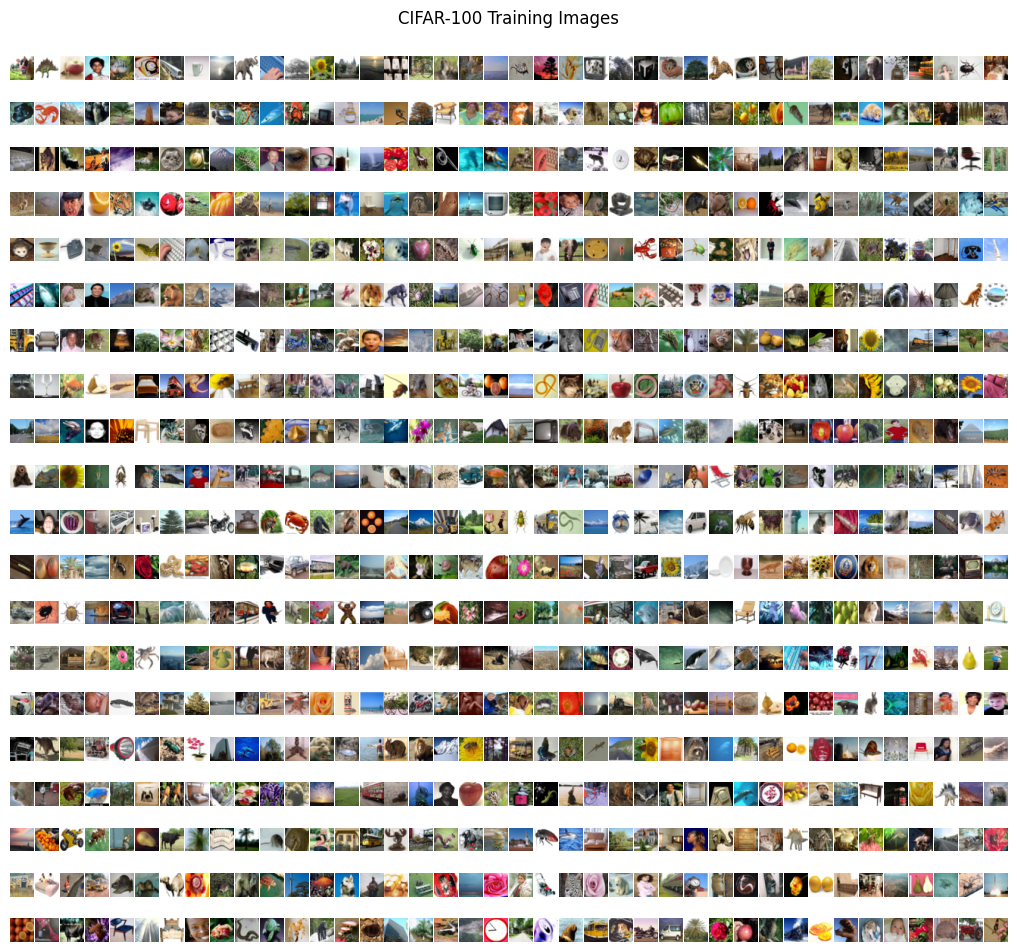

Fullscreen mode is not supported for this backend.
Plot saved to /kaggle/working/my_saved_models/Gray Training Images.png


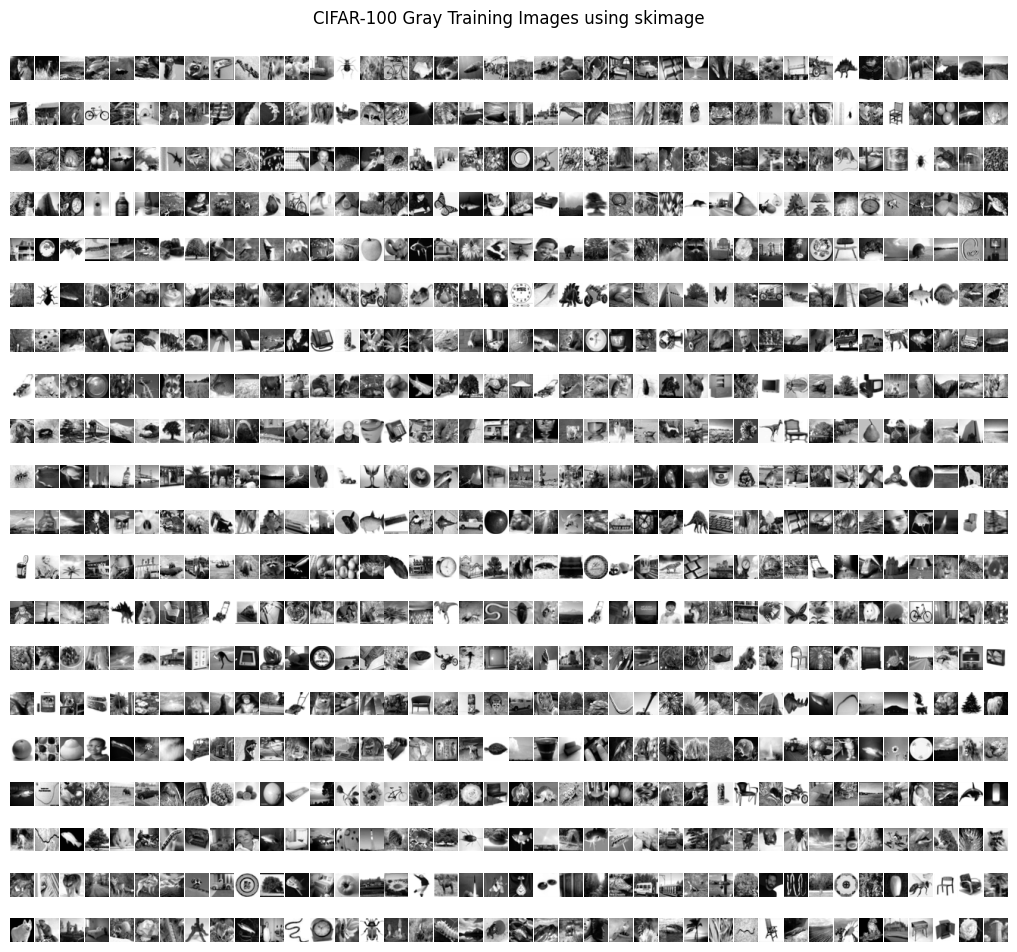

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       340,630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,630 (1.30 MB)

 Trainable params: 340,630 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


I0000 00:00:1733652091.884640     132 service.cc:145] XLA service 0x7b1cd4007d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733652091.884685     132 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733652091.884689     132 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733652092.129410     132 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1733652092.129508     132 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1733652092.131725     132 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1733652092.131889     132 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1733652092.132365     132 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1733652092.132564     132 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Asse

  81/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4018 - loss: 0.1588 - psnr_metric: 9.8181 - ssim_metric: 0.0745

I0000 00:00:1733652094.103854     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1229/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4916 - loss: 0.0596 - psnr_metric: 13.5577 - ssim_metric: 0.1560

W0000 00:00:1733652097.356040     130 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1733652097.357222     130 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1733652097.359323     130 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1733652097.360023     130 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1733652097.360913     130 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1733652097.361512     130 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
W0000 00:00:1733652098.282537     131 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1733652098.282708     131 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1733652098.283231     131 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1733652098.283455     131 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Asser


Epoch 1: val_psnr_metric improved from -inf to 15.10030, saving model to /kaggle/working/my_saved_models/CIFAR100-DenseAutoEncoderForColourization.001.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4917 - loss: 0.0594 - psnr_metric: 13.5737 - ssim_metric: 0.1565 - val_accuracy: 0.4746 - val_loss: 0.0357 - val_psnr_metric: 15.1003 - val_ssim_metric: 0.2105 - learning_rate: 0.0010
Epoch 2/100
1229/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5090 - loss: 0.0339 - psnr_metric: 15.3448 - ssim_metric: 0.2233
Epoch 2: val_psnr_metric improved from 15.10030 to 16.02232, saving model to /kaggle/working/my_saved_models/CIFAR100-DenseAutoEncoderForColourization.002.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5089 - loss: 0.0339 - psnr_metric: 15.3480 - ssim_metric: 0.2235 - val_accuracy: 0.4679 - val_loss: 0.0291 - val_psnr_metric: 16.0223 - val_ssim_metric: 0.2747 - learning_rate: 0.0010
Epoch 3/100
1236/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

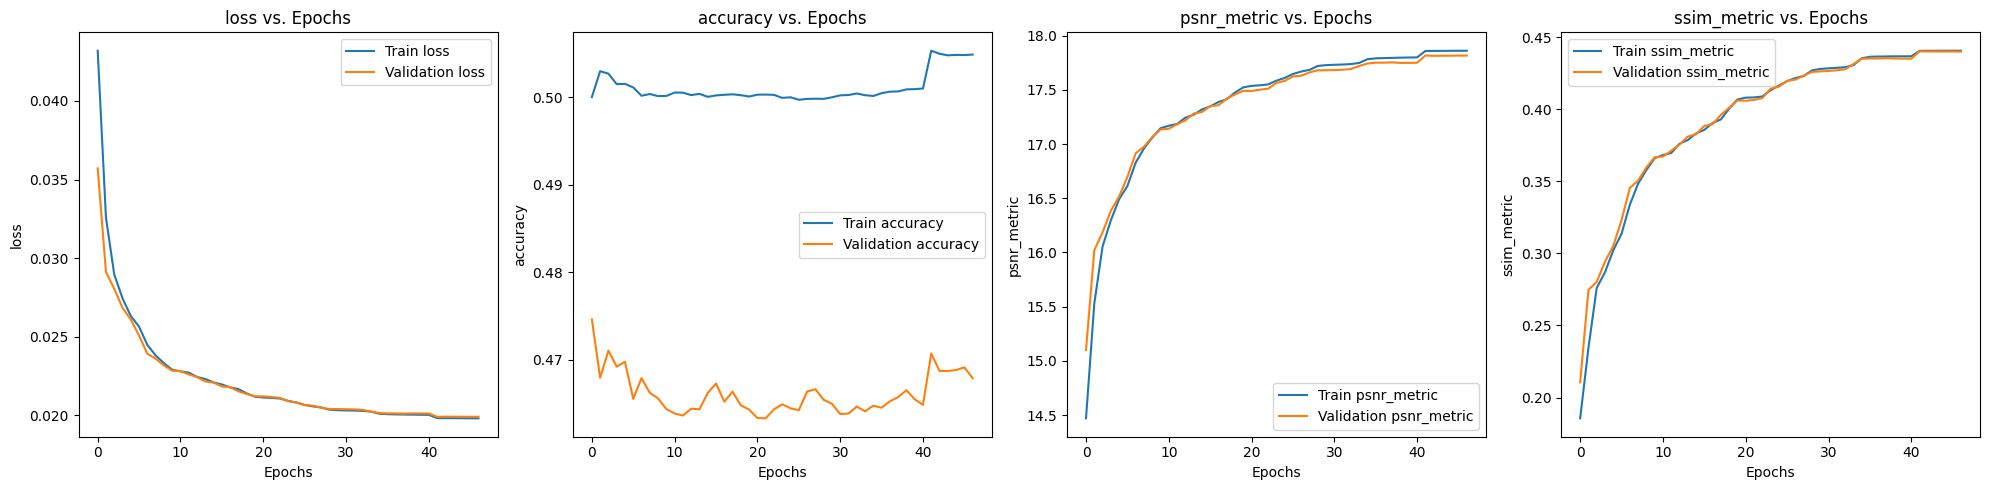

Plot saved to /kaggle/working/my_saved_models/CIFAR100-DenseAutoEncoderForColourization_results.png


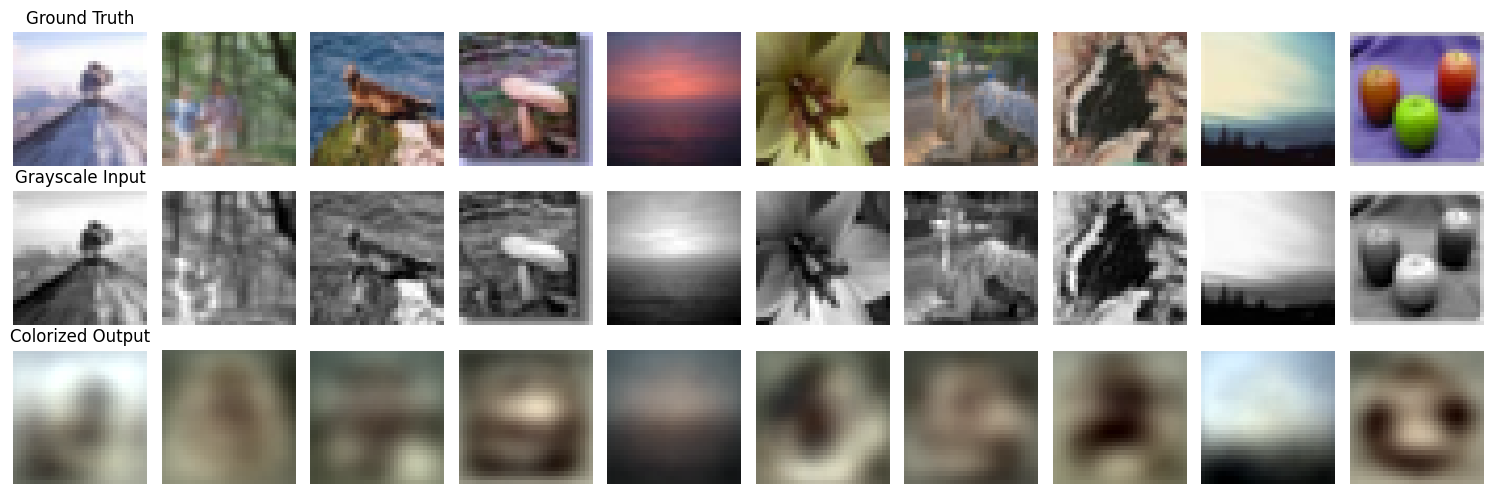

Plot saved to /kaggle/working/my_saved_models/CIFAR100-DenseAutoEncoderForColourization_Top10results.png


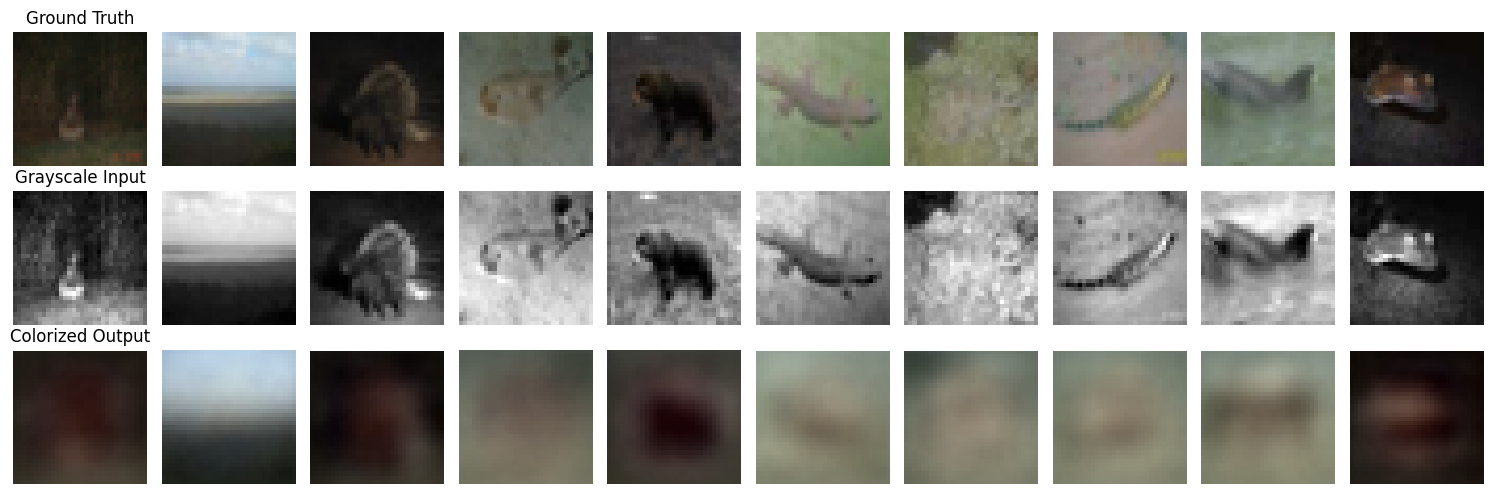

Fullscreen mode is not supported for this backend.
Plot saved to /kaggle/working/my_saved_models/CIFAR100-DenseAutoEncoderForColourization_Predicted Images.png


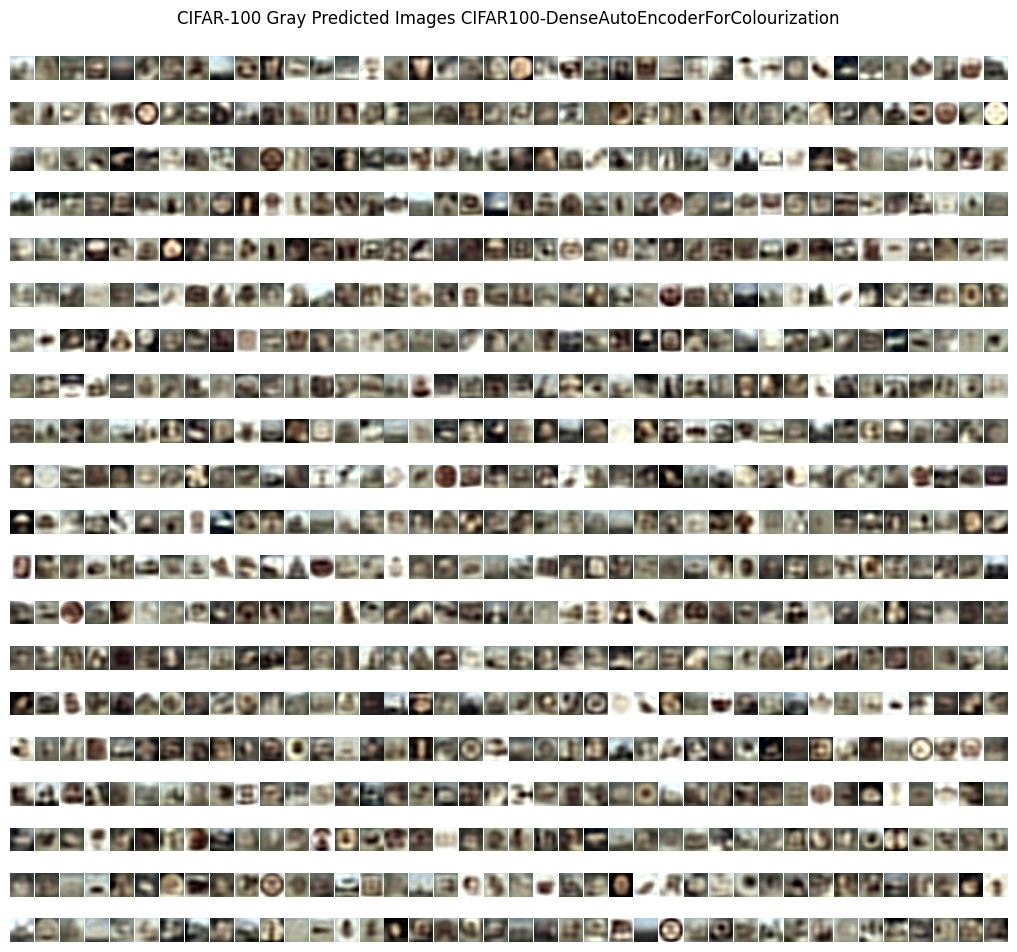

In [5]:

save_dir = os.path.join(os.getcwd(), 'my_saved_models')
os.makedirs(save_dir, exist_ok=True)
show_plot=True

x_train, x_test, x_train_gray, x_test_gray, x_train_color, x_val_gray, x_val_color=helpers.load_data_for_colourization(True,show_plot)

epochs=100
batch_size=32

CreateAndRunModel.create_and_run_model(DenseAutoEncoderForColourization,
    np.copy(x_train), np.copy(x_test), np.copy(x_train_gray), np.copy(x_test_gray), np.copy(x_train_color), 
    np.copy(x_val_gray), np.copy(x_val_color), save_dir, epochs, batch_size, show_plot=show_plot
)

